In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [77]:
# Read the airlines data frame and set index as Month
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

### Differencing the Time Series

In [67]:
#taking log difference of the time series 
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers'] = df['LogPassengers'].diff()
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [68]:
#dividing data set into train and test sets. We keep only the last 12 values for the test set and remaining for the train set. 
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

## Function to convert Time Series Data to a supervised dataset

In [69]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 
	df = pd.DataFrame(data)
	cols, col_names= list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		col_names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			col_names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			col_names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns= col_names
	

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	return agg


series= df['DiffLogPassengers'].to_numpy()

#defining parameters for one step forecast
lags= 10
supervised_df = series_to_supervised(series, lags) #second parameter specifies the number of inputs as X 

#building an array for the target variable from the above supervised time series data frame 
Y= supervised_df.iloc[:, -1].to_numpy()
#print(Y)

#remove the target column to simply combine the input columns into a single array
supervised_df =supervised_df.drop(supervised_df.columns[-1],axis=1)

X= supervised_df.values

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [70]:
#divide the data set into train and test sets
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)

X.shape (121, 10) (12, 10) 
Y.shape (121,) (12,)


# Linear Regression based forecast

In [71]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
print('Train accuracy: ', lr.score(Xtrain, Ytrain))
print('Test accuracy: ', lr.score(Xtest, Ytest))

Train accuracy:  0.6837135048453122
Test accuracy:  0.6492870172668167


We can see that the R2 scores for both train and test sets are not that great

In [72]:
# Boolean index- create indexing to address train and test sets
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:lags+1] = False # first lag+1 values are not predictable

In [73]:
#Reverse the differencing operation to get the data back to original format
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# 1-step forecast

In [74]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

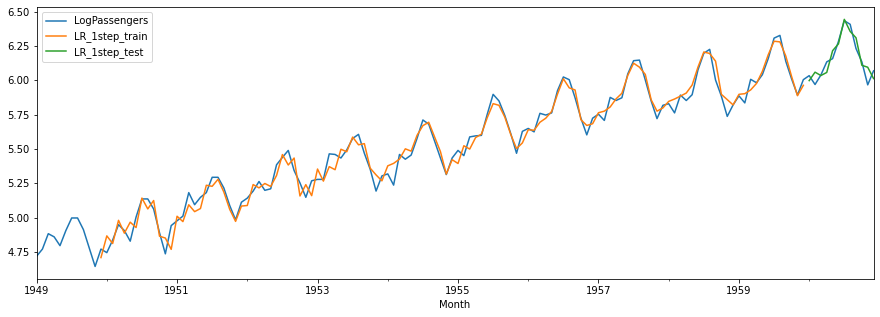

In [75]:
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

## Performing One-Step Forecast with N other models from sklearn package

              Model Name  Train Accuracy  Test Accuracy
0       LinearRegression        0.683714       0.649287
1                    SVR        0.659429       0.505295
2  RandomForestRegressor        0.967368       0.761108


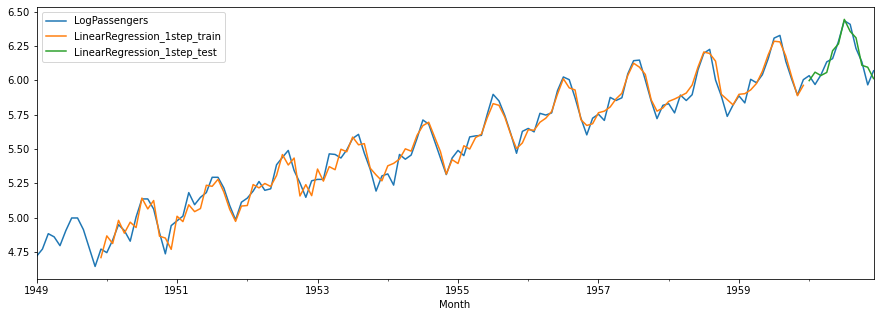

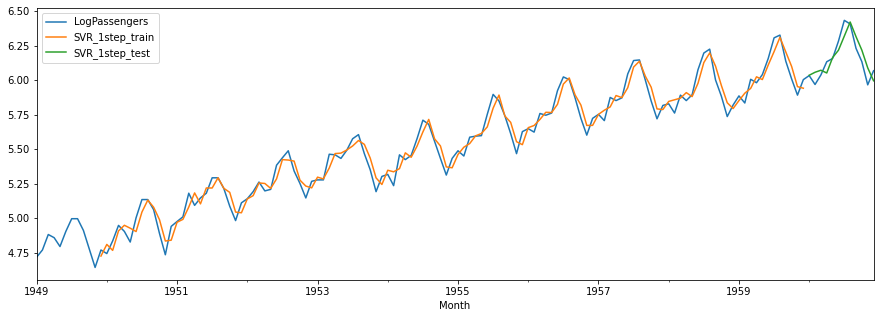

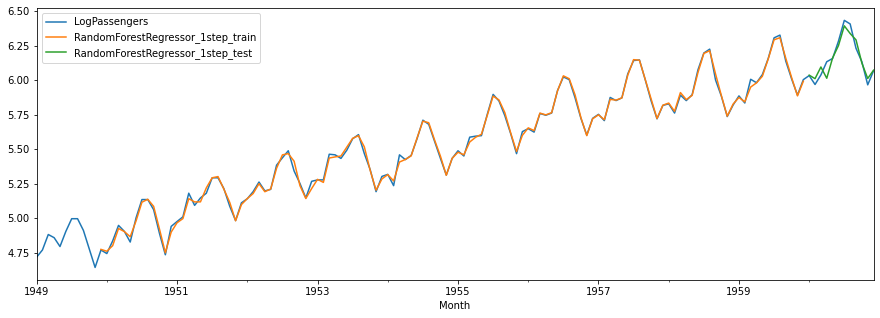

In [76]:
def one_step_forecast(model):
    model_results={}
    result_df=pd.DataFrame()

    if isinstance(model, list):
        model_names=[]
        train_r2=[]
        test_r2=[]

        for model_n in model:
            model_n.fit(Xtrain, Ytrain)

            #Reverse the differencing operation to get the data back to original format
            df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
            prev = df['ShiftLogPassengers']

            # 1-step forecast
            model_name = type(model_n).__name__
            model_names.append(model_name)
            train_r2.append(model_n.score(Xtrain, Ytrain))
            test_r2.append(model_n.score(Xtest, Ytest))
        
            df.loc[train_idx, model_name+'_1step_train'] = prev[train_idx] + model_n.predict(Xtrain)
            df.loc[test_idx, model_name+'_1step_test'] = prev[test_idx] + model_n.predict(Xtest)

            # plot 1-step forecast
            df[['LogPassengers', model_name+'_1step_train', model_name+'_1step_test']].plot(figsize=(15, 5))

        model_results= {'Model Name': model_names, 'Train Accuracy': train_r2, 
        'Test Accuracy': test_r2}

    
    else:
        model.fit(Xtrain, Ytrain)

        #Reverse the differencing operation to get the data back to original format
        df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
        prev = df['ShiftLogPassengers']

        # 1-step forecast
        model_name = type(model).__name__

        df.loc[train_idx, model_name+'_1step_train'] = prev[train_idx] + model.predict(Xtrain)
        df.loc[test_idx, model_name+'_1step_test'] = prev[test_idx] + model.predict(Xtest)

        # plot 1-step forecast
        df[['LogPassengers', model_name+'_1step_train', model_name+'_1step_test']].plot(figsize=(15, 5))

        #create a data frame with the result/ results
        #print(model_results)
        model_results= {'Model Name': model_name, 'Train Accuracy': model.score(Xtrain, Ytrain), 
        'Test Accuracy': model.score(Xtest, Ytest)}
    
    #create dataframe to display results
    results_agg= pd.DataFrame(model_results)
    print(results_agg)
    

one_step_forecast([LinearRegression(), SVR(), RandomForestRegressor()])


Next, let's see how multi step forecast works! 